# Exploratory Analysis of NYC High School Data (SAT Score)

This is a self practice of exploratory analysis investigating relationship between demographics and SAT score. The analysis also based on the survey collected. The analysis is attempting to see what are the factors that contributes to higher SAT score in NYC

# Data Preparation

### Read in the data

In [24]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

### Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

### Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

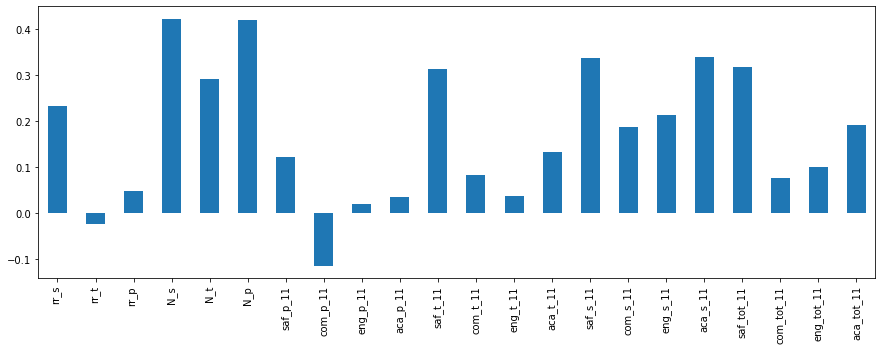

In [31]:
correlations[survey_fields].plot.bar(figsize=(15,5))

The analysis will be from left to right and only focuses on those columns with correlation higher than 0.2

- `rr_s` is student respond rate. It is weakly correlated with sat_score. With positive correlation, it could be that because those who respond are those who do well in th exam while those with low score may not feel confident to respond to the survey 
<br>

- `N_s`, `N_t` ,`N_p` have high correaltion to the `sat_score`. This makes sense as there are the number of respondants which is basically correlated to the total_enrollment.
<br><br>
- `saf_t_11`, `saf_s_11`, these are how student and teacher perceived safty. With safty environment, teachers and student could focus more on learning and teaching, thus it could be the reason that they are positively correlates to the sat_score. With the magnitude of these two score, it explains why `saf_tot_11` is also high as it is the total safty and respect score. <br><br>

- `aca_s_11` is academic expectations score based on student response. While `aca_s_11` correlates with `sat_score`, it is not the same case for parent expectation (`aca_p_11`) and teacher expectation (`aca_t_11`)
<br><br>

Base on the findings above, the exploration will be around these findings to see if they hold true

# Exploring Safety

Text(0, 0.5, 'Sat Score')

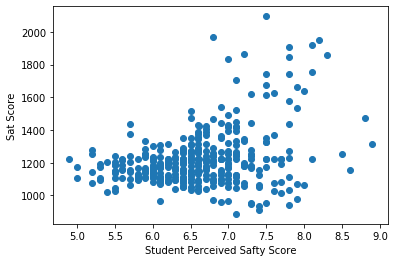

In [33]:
plt.scatter(x = combined['saf_s_11'], y= combined['sat_score'])
plt.xlabel('Student Perceived Safty Score')
plt.ylabel('Sat Score')

While the trend we see earlier can be observed, the trend is not so strong. It is possible to see school with high sat score and high safety and school with low sat score and low safety. One key observation is that schools with lower than 7 safety score, tend to have sat score below 1600 but schools with safety score above 7 have sat score range from below 1000 to above 2000.

# Exploring Race
- `white_per`
- `asian_per`
- `black_per`
- `hispanic_per`

In [36]:
race= ['white_per','asian_per','black_per','hispanic_per']

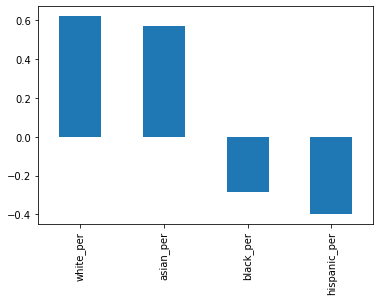

In [43]:
combined.corr()['sat_score'][race].plot.bar()

School with higher percentage of white and asian tends to have higher sat score while school with higher black and hispanic tend to have lower sat score.

Text(0, 0.5, 'Sat Score')

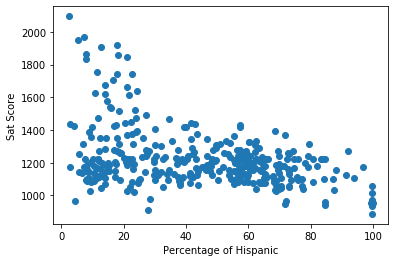

In [45]:
plt.scatter(x = combined['hispanic_per'], y= combined['sat_score'])
plt.xlabel('Percentage of Hispanic')
plt.ylabel('Sat Score')

With lower percentage of hispanic, the sat score can be very high (>2000) and very low (<1000). But the key point is that with the percentage of hispanic above 35 percent, the sat score tends to stay below 1400

In [47]:
# See the school with more than 95% of hispanic
combined[combined['hispanic_per'] > 95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Based on the name and some google search, these school have a lot of student who are learning English and this could explain the low SAT score

In [51]:
# See the school with less than 10% hispanic and SAT score more than 1800
combined[(combined['hispanic_per'] < 10) & (combined['sat_score']>1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These school are specialized in science and technology. They take in student based on admission exam and they also receive additional funding. This does not explain in term of race but does explain the high score on SAT. The school takes student all over NYC who passes the test.

# Exploring Gender

In [52]:
gender = ['male_per','female_per']

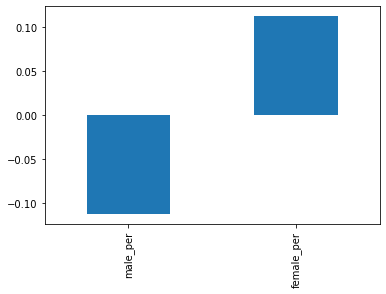

In [56]:
combined.corr()['sat_score'][gender].plot.bar()

No strong correlation is observed here in Gender differences. But it is observed that with greater percentage of female, the SAT score tend to be higher while with greater percentage of male will contribute to lower SAT score

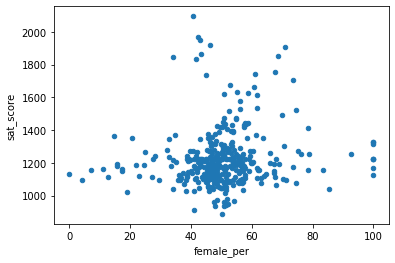

In [58]:
combined.plot.scatter('female_per','sat_score')

There is no strong relationship observe but with female percentage in school ranging from 40% - 80%, the SAT score could be above 1400

In [59]:
combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools are selective liberal arts schools and they also have high academic standards

# Exploring AP exam score VS SAT score

AP exams is a test where high school students take to assess their capability to work at the college level in the subject. Taking AP exams also earn students. <br><br>
It is imaginable that the number of student at a school who tool AP exam would be highly correlated with the school's SAT scores. Also, with high correlation between SAT score and total enrollment, to be on the safe side that we are not bias, we will also consider the percentage og student in each school who took at least one AP exam

In [64]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

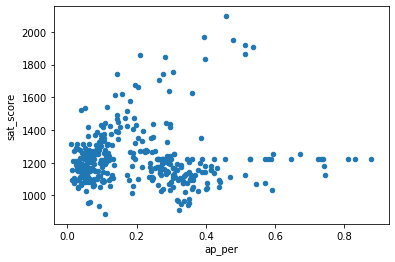

In [65]:
combined.plot.scatter('ap_per','sat_score')

Although, it seems like there is a relationship between the percentage of students in a school who take the AP exam, no strong relationship is observed.

# Exploring class size

In [77]:
combined.corr()['sat_score']['AVERAGE CLASS SIZE']

0.3810143308095523

Based on the correlation calculation the class size has a relationship with SAT score

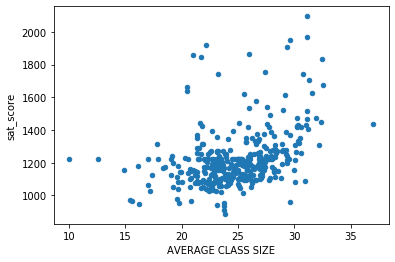

In [78]:
combined.plot.scatter('AVERAGE CLASS SIZE','sat_score')

With average class size between 20 to 30 students, the SAT score is highest. However, it cannot be concluded that this is the case as there is not strong relationship observed